# Assignment 2

**Credits**: Andrea Galassi, Federico Ruggeri, Paolo Torroni

**Keywords**: Transformers, Question Answering, CoQA

## Deadlines

* **December 11**, 2022: deadline for having assignments graded by January 11, 2023
* **January 11**, 2023: deadline for half-point speed bonus per assignment
* **After January 11**, 2023: assignments are still accepted, but there will be no speed bonus

## Overview

### Problem

Question Answering (QA) on [CoQA](https://stanfordnlp.github.io/coqa/) dataset: a conversational QA dataset.

### Task

Given a question $Q$, a text passage $P$, the task is to generate the answer $A$.<br>
$\rightarrow A$ can be: (i) a free-form text or (ii) unanswerable;

**Note**: an question $Q$ can refer to previous dialogue turns. <br>
$\rightarrow$ dialogue history $H$ may be a valuable input to provide the correct answer $A$.

### Models

We are going to experiment with transformer-based models to define the following models:

1.  $A = f_\theta(Q, P)$

2. $A = f_\theta(Q, P, H)$

where $f_\theta$ is the transformer-based model we have to define with $\theta$ parameters.

## The CoQA dataset

<center>
    <img src="https://drive.google.com/uc?export=view&id=16vrgyfoV42Z2AQX0QY7LHTfrgektEKKh" width="750"/>
</center>

For detailed information about the dataset, feel free to check the original [paper](https://arxiv.org/pdf/1808.07042.pdf).



## Rationales

Each QA pair is paired with a rationale $R$: it is a text span extracted from the given text passage $P$. <br>
$\rightarrow$ $R$ is not a requested output, but it can be used as an additional information at training time!

## Dataset Statistics

* **127k** QA pairs.
* **8k** conversations.
* **7** diverse domains: Children's Stories, Literature, Mid/High School Exams, News, Wikipedia, Reddit, Science.
* Average conversation length: **15 turns** (i.e., QA pairs).
* Almost **half** of CoQA questions refer back to **conversational history**.
* Only **train** and **validation** sets are available.

## Dataset snippet

The dataset is stored in JSON format. Each dialogue is represented as follows:

```
{
    "source": "mctest",
    "id": "3dr23u6we5exclen4th8uq9rb42tel",
    "filename": "mc160.test.41",
    "story": "Once upon a time, in a barn near a farm house, there lived a little white kitten named Cotton. 
    Cotton lived high up in a nice warm place above the barn where all of the farmer's horses slept. [...]" % <-- $P$
    "questions": [
        {
            "input_text": "What color was Cotton?",   % <-- $Q_1$
            "turn_id": 1
        },
        {
            "input_text": "Where did she live?",
            "turn_id": 2
        },
        [...]
    ],
    "answers": [
        {
            "span_start": 59,   % <-- $R_1$ start index
            "spand_end": 93,    % <-- $R_1$ end index
            "span_text": "a little white kitten named Cotton",   % <-- $R_1$
            "input_text" "white",   % <-- $A_1$      
            "turn_id": 1
        },
        [...]
    ]
}
```

### Simplifications

Each dialogue also contains an additional field ```additional_answers```. For simplicity, we **ignore** this field and only consider one groundtruth answer $A$ and text rationale $R$.

CoQA only contains 1.3% of unanswerable questions. For simplicity, we **ignore** those QA pairs.

## Dataset Download


In [1]:
%%capture
!pip install transformers
!pip install allennlp_models

In [2]:
import os
import urllib.request
from tqdm import tqdm

class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)
        
def download_url(url, output_path):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=output_path, reporthook=t.update_to)

def download_data(data_path, url_path, suffix):    
    if not os.path.exists(data_path):
        os.makedirs(data_path)
        
    data_path = os.path.join(data_path, f'{suffix}.json')

    if not os.path.exists(data_path):
        print(f"Downloading CoQA {suffix} data split... (it may take a while)")
        download_url(url=url_path, output_path=data_path)
        print("Download completed!")

In [3]:
# Train data
train_url = "https://nlp.stanford.edu/data/coqa/coqa-train-v1.0.json"
download_data(data_path='coqa', url_path=train_url, suffix='train')

# Test data
test_url = "https://nlp.stanford.edu/data/coqa/coqa-dev-v1.0.json"
download_data(data_path='coqa', url_path=test_url, suffix='test')  # <-- Why test? See next slides for an answer!

coqa-train-v1.0.json: 49.0MB [00:08, 5.87MB/s]                            


Download completed!


coqa-dev-v1.0.json: 9.09MB [00:03, 2.86MB/s]                            

Download completed!


## [Task 1] Remove unaswerable QA pairs

Write your own script to remove unaswerable QA pairs from both train and validation sets.

In [4]:
import json
import torch
import pandas as pd
import numpy as np
import sys
import shutil

In [5]:
def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use. 
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

fix_random(seed=42)

Now we remove the **unanswerable** QA pairs by accessing both the `train folder` and the `test folder` and checking for **answers** where `input_text` is **unknown**. Additionally, we reindexed the `turn id` such that we don't have discrepancies in the turn number.

In [6]:
dataset_folder = "coqa/"

df = []
deleted_pairs = 0
deleted_files = 0
for split in ["train", "test"]:
  json_file = split + '.json'

  # Read json file
  try:
    with open(os.path.join(dataset_folder, json_file)) as f:
      text = json.load(f)
      f.close()
  except Exception as e:
    print('Failed to process %s. Reason: %s' % (os.path.join(dataset_folder, json_file), e))
    sys.exit(0)
  
  # Collect the data into a DataFrame
  for data in text["data"]:

    dataframe_row = {'source'   : data['source'],
                     'id'       : data['id'],
                     'story'    : data['story'],
                     'questions': [],
                     'answers'  : [],
                     'split'    : split,
                     'QA_length': 0}

    # Delete 'unanswerable' QA pairs
    turn_id = 0
    for idx in range(len(data["answers"])):

      if data["answers"][idx]["input_text"] != "unknown":
        turn_id += 1

        # QUESTION
        dataframe_row['questions'].append(
            {
            'input_text': data['questions'][idx]['input_text'],
            'turn_id'   : turn_id
            })

        # ANSWER + RATIONALE
        dataframe_row['answers'].append(
            {
            'input_text': data['answers'][idx]['input_text'],
            'rationale' : data['answers'][idx]['span_text'],
            'span_start': data['answers'][idx]['span_start'],
            'span_end'  : data['answers'][idx]['span_end'],
            'turn_id'   : turn_id
            })
        
      else:
        deleted_pairs += 1
      
    dataframe_row['QA_length'] = turn_id

    # Delete texts without any valid QA pair
    if turn_id > 0:
      df.append(dataframe_row)
    else:
      deleted_files += 1

df = pd.DataFrame(df)

print(f"Number of deleted QA pairs: {deleted_pairs}")
print(f"Number of deleted files: {deleted_files}")
print()

print(f"Number of remaining QA pairs: {df['QA_length'].sum()}")
print(f"Number of remaining files: {df.shape[0]}")
print(f"Number of unique IDs: {len(df['id'].unique())}")
print()

# All files are unique and contain at least a 'good' QA pair
if df.shape[0] == len(df['id'].unique()) and np.sum(df['QA_length'] == 0) == 0:
  print("All good for now...")

  # ...better to save it!
  dataframe_path = os.path.join(dataset_folder, "dataframe.pkl")
  df.to_pickle(dataframe_path)
else:
  print("Something strange to check!!!")

Number of deleted QA pairs: 1437
Number of deleted files: 6

Number of remaining QA pairs: 115193
Number of remaining files: 7693
Number of unique IDs: 7693

All good for now...


In [7]:
dataframe_path = os.path.join(dataset_folder, "dataframe.pkl")

df = pd.read_pickle(dataframe_path)
df.head()

,source,id,story,questions,answers,split,QA_length
0,wikipedia,3zotghdk5ibi9cex97fepx7jetpso7,"The Vatican Apostolic Library (), more commonl...",[{'input_text': 'When was the Vat formally ope...,[{'input_text': 'It was formally established i...,train,19
1,cnn,3wj1oxy92agboo5nlq4r7bndc3t8a8,New York (CNN) -- More than 80 Michael Jackson...,"[{'input_text': 'Where was the Auction held?',...","[{'input_text': 'Hard Rock Cafe', 'rationale':...",train,5
2,gutenberg,3bdcf01ogxu7zdn9vlrbf2rqzwplyf,"CHAPTER VII. THE DAUGHTER OF WITHERSTEEN \n\n""...",[{'input_text': 'What did Venters call Lassite...,"[{'input_text': 'gun-man', 'rationale': 'this ...",train,20
3,cnn,3ewijtffvo7wwchw6rtyaf7mfwte0p,(CNN) -- The longest-running holiday special s...,"[{'input_text': 'Who is Rudolph's father?', 't...","[{'input_text': 'Donner', 'rationale': 'Santa'...",train,20
4,gutenberg,3urfvvm165iantk80llvkwwbjs7uzh,CHAPTER XXIV. THE INTERRUPTED MASS \n\nThe mor...,"[{'input_text': 'Who arrived at the church?', ...","[{'input_text': 'the garrison first', 'rationa...",train,10


#### Data Inspection

Spend some time in checking accurately the dataset format and how to retrieve the tasks' inputs and outputs!

In [8]:
print(f"Number of remaining files: {df.shape[0]}")
print(f"How many are the unique stories? {len(df['story'].unique())}")
print()

print("How should we manage these files?")

Number of remaining files: 7693
How many are the unique stories? 7070

How should we manage these files?


Quick check of these duplicated texts...

- Run the following cell and simply look at some of them in the 'duplicates' folder!

-> They contain different Questions and Answers, so we should have no problems in keeping all of them...

In [9]:
# How many files do you want to visualize?
file_limit = 3

if 'duplicates' in os.listdir():
  shutil.rmtree('duplicates')
!mkdir 'duplicates'

count = {}

for story in df['story']:
  if story not in count.keys():
    count[story] = 1
  else:
    count[story] += 1

for story in df['story']:
  if file_limit == 0:
    break

  if story in count.keys():
    if count[story] > 1:
      file_limit -= 1
      indices = np.where(df['story'] == story)[0]

      f = open("duplicates/"+str(indices[0])+'_'+str(len(indices))+".txt", "w")

      f.write(story)
      f.write('\n\n\n')
      for idx in indices:
        for pair in range(df.loc[idx, 'QA_length']):
          f.write(f"Q: {df.loc[idx, 'questions'][pair]['input_text']}\n")
          f.write(f"A: {df.loc[idx, 'answers'][pair]['input_text']}\n")
        f.write('\n')

      f.close()

In [10]:
print(f"Dictionary keys: {list(df.keys())}")

Dictionary keys: ['source', 'id', 'story', 'questions', 'answers', 'split', 'QA_length']


In [11]:
print(df.loc[0, 'story'])

The Vatican Apostolic Library (), more commonly called the Vatican Library or simply the Vat, is the library of the Holy See, located in Vatican City. Formally established in 1475, although it is much older, it is one of the oldest libraries in the world and contains one of the most significant collections of historical texts. It has 75,000 codices from throughout history, as well as 1.1 million printed books, which include some 8,500 incunabula. 

The Vatican Library is a research library for history, law, philosophy, science and theology. The Vatican Library is open to anyone who can document their qualifications and research needs. Photocopies for private study of pages from books published between 1801 and 1990 can be requested in person or by mail. 

In March 2014, the Vatican Library began an initial four-year project of digitising its collection of manuscripts, to be made available online. 

The Vatican Secret Archives were separated from the library at the beginning of the 17th

In [12]:
print(f"Questions dictionary keys:  {list(df.loc[0, 'questions'][0].keys())}")
print(f"  Answers dictionary keys:  {list(df.loc[0, 'answers'][0].keys())}")

Questions dictionary keys:  ['input_text', 'turn_id']
  Answers dictionary keys:  ['input_text', 'rationale', 'span_start', 'span_end', 'turn_id']


In [13]:
print("EXAMPLE OF A QUESTION/ANSWER PAIR:\n")
print("Question ->", end=" ")
print(df.loc[0, 'questions'][0])

print("  Answer ->", end=" ")
print(df.loc[0, 'answers'][0])

EXAMPLE OF A QUESTION/ANSWER PAIR:

Question -> {'input_text': 'When was the Vat formally opened?', 'turn_id': 1}
  Answer -> {'input_text': 'It was formally established in 1475', 'rationale': 'Formally established in 1475', 'span_start': 151, 'span_end': 179, 'turn_id': 1}


In [14]:
print("Conversation Structure:\n")
for idx in range(df.loc[0, 'QA_length']):
  question = df.loc[0, 'questions'][idx]
  answer = df.loc[0, 'answers'][idx]

  print(f"Turn {idx+1}")
  print(f"R: {answer['rationale']}")
  print(f"Q: {question['input_text']}")
  print(f"A: {answer['input_text']}")
  print()

Conversation Structure:

Turn 1
R: Formally established in 1475
Q: When was the Vat formally opened?
A: It was formally established in 1475

Turn 2
R: he Vatican Library is a research library
Q: what is the library for?
A: research

Turn 3
R: Vatican Library is a research library for history, law
Q: for what subjects?
A: history, and law

Turn 4
R: Vatican Library is a research library for history, law, philosophy, science and theology
Q: and?
A: philosophy, science and theology

Turn 5
R: March 2014, the Vatican Library began an initial four-year project of digitising its collection of manuscripts
Q: what was started in 2014?
A: a  project

Turn 6
R: Scholars have traditionally divided the history of the library into five period
Q: how do scholars divide the library?
A: into periods

Turn 7
R: Scholars have traditionally divided the history of the library into five periods
Q: how many?
A: five

Turn 8
R: Vatican Apostolic Library (), more commonly called the Vatican Library or simply 

From the conversation above we can think to retrieve the inputs (Q, P) or (Q, P, H) directly from the cells ['story', 'questions' and 'answers'] of the DataFrame.

In [15]:
print("Distribution of splits: ")
print(df['split'].value_counts())
print()

Distribution of splits: 
train    7193
test      500
Name: split, dtype: int64



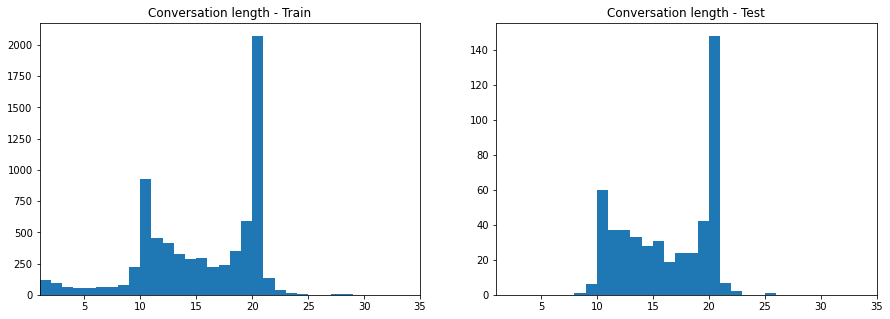

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
train_indices = (df['split'] == 'train')
plt.hist(df.loc[train_indices, 'QA_length'], bins=range(1, 36))
plt.xlim((1, 35))
plt.title("Conversation length - Train")

plt.subplot(1,2,2)
test_indices = (df['split'] == 'test')
plt.hist(df.loc[test_indices, 'QA_length'], bins=range(1, 36))
plt.xlim((1, 35))
plt.title("Conversation length - Test")
plt.show()

## [Task 2] Train, Validation and Test splits

CoQA only provides a train and validation set since the test set is hidden for evaluation purposes.

We'll consider the provided validation set as a test set. <br>
$\rightarrow$ Write your own script to:
* Split the train data in train and validation splits (80% train and 20% val)
* Perform splits such that a dialogue appears in one split only! (i.e., split at dialogue level)
* Perform splitting using the following seed for reproducibility: 42

#### Reproducibility Memo

Check back tutorial 2 on how to fix a specific random seed for reproducibility!

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In the following cell we proceeded to split the `DataFrame` in 3 parts: 

*   Training Set
*   Validation Set
*   Test Set



In [18]:
def split_data(df, seed):
  """
  Inputs:
    - DataFrame
    - seed

  Returns:
    - Train set : DataFrame
    - Val set   : DataFrame
    - Test set  : DataFrame
  """
  df_train, df_val = train_test_split(df[df['split'] == 'train'], train_size=0.8, random_state=seed)
  df_val['split'] = 'val'
  df_test = df[df['split'] == 'test']

  df_train.reset_index(drop=True, inplace=True)
  df_val.reset_index(drop=True, inplace=True)
  df_test.reset_index(drop=True, inplace=True)

  return df_train, df_val, df_test

df_train, df_val, df_test = split_data(df, 42)
print(f"Train files: {df_train.shape[0]}  ({(100 *df_train.shape[0] / df.shape[0]):.1f}%)")
print(f"  Val files: {df_val.shape[0]}  ({(100 *df_val.shape[0] / df.shape[0]):.1f}%)")
print(f" Test files:  {df_test.shape[0]}   ({(100 *df_test.shape[0] / df.shape[0]):.1f}%)")

Train files: 5754  (74.8%)
  Val files: 1439  (18.7%)
 Test files:  500   (6.5%)


Now we preprocessed the data by extracting only the useful information from the `DataFrames` and adding the **history (H)**, to it. 

The **history** can be set to have a fixed length (e.g. hist_length = 3 will take only the 3 previous **QA pairs** as history)

$H = Q_{n-3} + A_{n-3} + Q_{n-2} + A_{n-2} + Q_{n-1} + A_{n-1}$

where `n` indicates the actual turn ($Q_{n}$ is the actual Question).



In [19]:
def preprocess_data(df, hist_length=3):
  """
  Inputs:
    - DataFrame w/o History
    - Length of the History

  Returns:
    - Preprocessed DataFrame with History
  """
  processed_data = []

  for _, row in df.iterrows():
    qa_pairs = list(zip(row['questions'], row['answers']))
    for idx, (question, answer) in enumerate(qa_pairs):
      
      # Create history
      history = ''.join([qa_pairs[i][0]['input_text'] + ' ' + qa_pairs[i][1]['input_text'] + '. ' for i in range(max(0, idx-hist_length), idx)])

      data = {
              'source'    : row['source'],
              'passage'   : row['story'],
              'question'  : question['input_text'],
              'answer'    : answer['input_text'],
              'rationale' : answer['rationale'],
              'span_start': answer['span_start'],
              'span_end'  : answer['span_end'],
              'history'   : history
              }
    
      processed_data.append(data)

  processed_data = shuffle(pd.DataFrame(processed_data), random_state=42)
  processed_data.reset_index(drop=True, inplace=True)
  return processed_data

train_data = preprocess_data(df_train, hist_length=3)
val_data   = preprocess_data(df_val,   hist_length=3)
test_data  = preprocess_data(df_test,  hist_length=3)

In [20]:
train_data.head()

,source,passage,question,answer,rationale,span_start,span_end,history
0,mctest,Mary loved walking through the woods with her ...,Where did they like to hide?,Behind the raspberry bushes.,their secret hiding place behind the raspberry...,445,498,What did they look for together? Blueberries. ...
1,cnn,"(CNN) -- Tragically, another celebrity has die...",which country singer's death is in the headlines?,Mindy McCready,Country singer Mindy McCready's death,136,174,what was Wyatt D.'s cause of death? drug-relat...
2,wikipedia,Vermont () is a state in the New England regio...,Which force represented the New Hampshire colo...,Green Mountain Boys militia,Settlers who held land titles granted by New Y...,1309,1495,During what historic event? Seven Years' War. ...
3,race,"When Charles Stratton was five, he stopped gro...",Who did Tom marry?,Lavinia Warren,"One of the little people was Lavinia Warren, a...",965,1075,What was Charles Stratton's nickname? General ...
4,mctest,The turtle and the fox were best friends. One ...,What did Turtle want to do with him?,go fishing,he wanted to go fishing,636,659,Who was Turtle friends with? fox.


## [Task 3] Model definition

Write your own script to define the following transformer-based models from [huggingface](https://HuggingFace.co/).

* [M1] DistilRoBERTa (distilberta-base)
* [M2] BERTTiny (bert-tiny)

**Note**: Remember to install the ```transformers``` python package!

**Note**: We consider small transformer models for computational reasons!

In [21]:
import transformers
from transformers import AutoTokenizer
from transformers import EncoderDecoderModel, AutoModelForQuestionAnswering

import gc
import warnings
import wandb

from torch.utils.data import Dataset, DataLoader
from allennlp_models.rc.tools import squad

## Models

The models we are going to use are based on two architectures stacked together:


1.   **Span Extractor** (Bert/Roberta for Question-Answering)
2.   **Answer Generator** (Bert/Roberta Encoder-Decoder)

The idea is to use `Span Extractor` to predict the **Rationale** (the sentence where we can find the answer) that will make it easier for the `Answer Generator` to predict the answer.

To do that, we have to pass the **Question & Passage** to the `Span Extractor` so that we get the **Span Start Index & Span End Index**.

Then retrieve the Rationale from the Passage by considering the tokens lying between these indexes. Now we can create the input for the `Answer Generator` that will include both **Question & Rationale**.

<br>

In short:

Question + Passage -> `Span Extractor` -> Rationale -> Question + Rationale -> `Answer Generator` -> Answer

<br>

**THEACHER FORCING**

Since the training of the `Answer Generator` is heavily dependent on the rationale it gets as input, we used a **Teacher Forcing** approach. This means that in the first steps (when the Rationale predicted from the first network is not good) the Encoder-Decoder will use the **ground truth rationale** to predict the answer. The likelihood of this happening decreases linearly as training progresses.

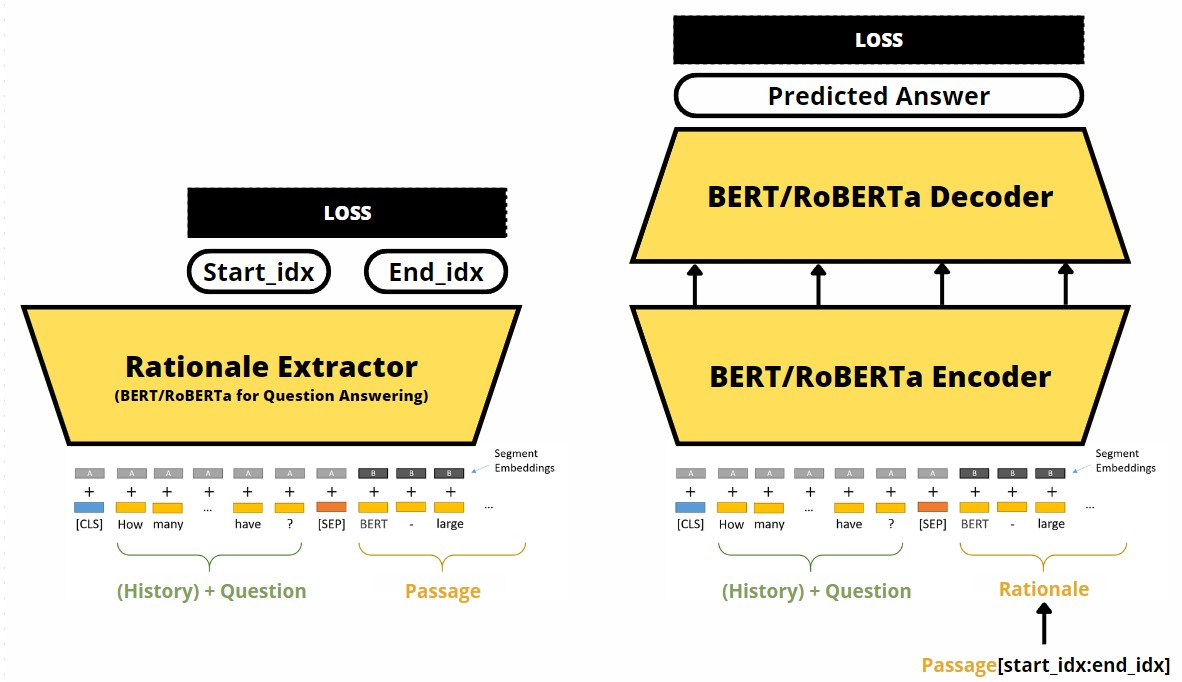

### DistilRoBERTa

Inputs accepted by **RoBERTa** are of the following form (depending on whether we include the history or not):

*   \[CLS] Q \[SEP] \[SEP] P \[SEP] \*\[PAD]
*   \[CLS] Q \[SEP] \[SEP] R \[SEP] \*\[PAD]
*   \[CLS] H + Q \[SEP] \[SEP] P \[SEP] \*\[PAD]
*   \[CLS] H + Q \[SEP] \[SEP] R \[SEP] \*\[PAD]

where H + Q means that the **History ( H )** has been prepended to the current **Question ( Q )**, and the `*` means that the **Padding ( \[PAD] )** may not be present. Usually when the **Padding** is present it includes more than just one token! (e.g. \[CLS] Q \[SEP] \[SEP] P \[SEP] \[PAD] ... \[PAD])

<br>

The most complex part is to re-create the input for the second model. In short:

1.   Get `start_idx/end_idx` predicted by the Span Extractor 
2.   Extract the Rationale which is `Passage[start_idx:end_idx]`
3.   Refine the **Rationale ( R )**, we want to `remove all the special tokens` (i.e. \[SEP] and \[PAD]; \[CLS] tokens can't be present here!)
4.   Compose the new input: \[CLS] Q \[SEP] **\[SEP] R \[SEP] \[PAD]**

**ATTENTION**: Only the part in **bold** of the point **4** is composed by hand. It must be appended to **\[CLS] Q \[SEP]** which is already present in the input of the `Span Extractor`! In the code \[CLS] Q \[SEP] is represented with the variable `quest`.



In [22]:
class M1(torch.nn.Module):
  def __init__(self, name='DistilRoBERTa', finetuned=True, tie_encoder_decoder=False, **kwargs):
    super(M1, self).__init__(**kwargs)
    self.name = name

    # Tokenizer
    self.tokenizer = AutoTokenizer.from_pretrained("distilroberta-base")

    # Rationale Extractor
    if finetuned:
        self.span_extractor = AutoModelForQuestionAnswering.from_pretrained("squirro/distilroberta-base-squad_v2")
    else:
        self.span_extractor = AutoModelForQuestionAnswering.from_pretrained("distilroberta-base")
    
    # Answer Generator
    self.answer_generator = EncoderDecoderModel.from_encoder_decoder_pretrained("distilroberta-base", 
                                                                                "distilroberta-base",
                                                                                tie_encoder_decoder=tie_encoder_decoder)
  
    # Set decoder configuration
    self.answer_generator.config.decoder.is_decoder = True
    self.answer_generator.config.decoder.add_cross_attention=True

    # Set model configuration
    self.answer_generator.config.decoder_start_token_id = self.tokenizer.cls_token_id
    self.answer_generator.config.pad_token_id = self.tokenizer.pad_token_id

    # Generation parameters
    self.answer_generator.config.max_length = 64
    self.answer_generator.config.min_length = 2
    self.answer_generator.config.no_repeat_ngram_size = 3
    self.span_extractor.config.finetuning_task = True
    self.answer_generator.config.finetuning_task = True
    self.answer_generator.config.repetition_penalty = 3.0
    self.answer_generator.config.num_beams = 10
    
  def forward(self, inputs, labels, teacher_perc, **kwargs):
      device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

      sep_token = torch.tensor([self.tokenizer.sep_token_id]).to(device)
      pad_token = torch.tensor([self.tokenizer.pad_token_id]).to(device)
      max_length = torch.tensor(inputs['input_ids'].shape[-1]).to(device)

      ##########################################################################
      ######################### SPAN EXTRACTOR NETWORK #########################
      ##########################################################################

      ############### Predict Rationale from Question + Passage ################
      span_out = self.span_extractor(input_ids=inputs['input_ids'],
                                     attention_mask=inputs['attention_mask'],
                                     start_positions=inputs['start_positions'],
                                     end_positions=inputs['end_positions'])
      
      span_loss = span_out['loss']

      ##########################################################################
      ######################## ENCODER-DECODER NETWORK #########################
      ##########################################################################
      if np.random.rand() < teacher_perc:
          
          ###### Predict Answer from Question + Rationale (GROUND TRUTH) #######
          gen_loss = self.answer_generator(input_ids=inputs['rationale_ids'],
                                           attention_mask=inputs['rationale_attention_mask'],
                                           labels=labels).loss
      
      else:
          ######### Re-create the input for the EncoderDecoder Network #########
          span_start = span_out['start_logits'].argmax(dim=-1)
          span_end = span_out['end_logits'].argmax(dim=-1)

          # Extract the *history + question - [CLS] H + Q [SEP] or [CLS] Q [SEP]
          quest = list(map(lambda x: x[:(x == sep_token).nonzero()[0][0] + 1], inputs['input_ids']))
          
          # Extract the predicted rationale
          rat = list(map(lambda x, q, s, e: 
                          x[len(q)+s:len(q)+e] if len(q) + s < max_length and e > s else
                          x[len(q):],
                          inputs['input_ids'], quest, span_start, span_end))
          
          # Remove 1st [SEP] token if present
          rat = list(map(lambda x: 
                          x[1:] if x[0] == sep_token else   
                          x,                                                                                                                      
                          rat))
        
          # Remove separator and padding tokens from the end
          rat = list(map(lambda x: 
                          x[:(x == sep_token).nonzero()[0][0]] if (sep_token in x) else   # R [SEP] -> R;  R [SEP] [PAD] -> R
                          x,                                                              # R -> R
                          rat))
          
          # Re-create the input - [CLS] Q [SEP] [SEP] R [SEP] *[PAD];  * -> may not be present
          gen_ids = list(map(lambda q, r: 
                             torch.cat((q, sep_token, r[:max_length-len(q)-2], sep_token)).cpu().numpy() if len(r) > max_length - len(q) - 2 else
                             torch.cat((q, sep_token, r, sep_token, torch.tensor([pad_token] * (max_length - len(q) - len(r) - 2)).to(device))).cpu().numpy(),
                             quest, rat))
          
          # Input ids
          gen_ids = np.array(gen_ids, copy=False)
          gen_ids = torch.tensor(gen_ids, dtype=torch.int64).to(device)

          # Attention Mask
          gen_att = torch.tensor(torch.where(gen_ids != pad_token, 1, 0), dtype=torch.int64).to(device)
          
          ######## Predict Answer from Question + Rationale (PREDICTED) ########
          gen_loss = self.answer_generator(input_ids=gen_ids,
                                           attention_mask=gen_att,
                                           labels=labels).loss
      
      return {'loss': gen_loss + span_loss,
              'span_loss': span_loss,
              'gen_loss': gen_loss}
    
  
  def generate(self, inputs, **kwargs):
      device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

      sep_token = torch.tensor([self.tokenizer.sep_token_id]).to(device)
      pad_token = torch.tensor([self.tokenizer.pad_token_id]).to(device)
      max_length = torch.tensor(inputs['input_ids'].shape[-1]).to(device)

      ##########################################################################
      ######################### SPAN EXTRACTOR NETWORK #########################
      ##########################################################################

      ############### Predict Rationale from Question + Passage ################
      span_out = self.span_extractor(input_ids=inputs['input_ids'],
                                     attention_mask=inputs['attention_mask'])
      
      ##########################################################################
      ######################## ENCODER-DECODER NETWORK #########################
      ##########################################################################
      
      ########### Re-create the input for the EncoderDecoder Network ###########
      span_start = span_out['start_logits'].argmax(dim=-1)
      span_end = span_out['end_logits'].argmax(dim=-1)

      # Extract the *history + question - [CLS] H + Q [SEP] or [CLS] Q [SEP]
      quest = list(map(lambda x: x[:(x == sep_token).nonzero()[0][0] + 1], inputs['input_ids']))
      
      # Extract the predicted rationale
      rat = list(map(lambda x, q, s, e: 
                      x[len(q)+s:len(q)+e] if len(q) + s < max_length and e > s else
                      x[len(q):],
                      inputs['input_ids'], quest, span_start, span_end))
      
      # Remove 1st [SEP] token if present
      rat = list(map(lambda x: 
                      x[1:] if x[0] == sep_token else   
                      x,                                                                                                                      
                      rat))
    
      # Remove separator and padding tokens from the end
      rat = list(map(lambda x: 
                      x[:(x == sep_token).nonzero()[0][0]] if (sep_token in x) else   # R [SEP] -> R;  R [SEP] [PAD] -> R
                      x,                                                              # R -> R
                      rat))
      
      # Re-create the input - [CLS] Q [SEP] [SEP] R [SEP] *[PAD];  * -> may not be present
      gen_ids = list(map(lambda q, r: 
                          torch.cat((q, sep_token, r[:max_length-len(q)-2], sep_token)).cpu().numpy() if len(r) > max_length - len(q) - 2 else
                          torch.cat((q, sep_token, r, sep_token, torch.tensor([pad_token] * (max_length - len(q) - len(r) - 2)).to(device))).cpu().numpy(),
                          quest, rat))
      
      # Input ids
      gen_ids = np.array(gen_ids, copy=False)
      gen_ids = torch.tensor(gen_ids, dtype=torch.int64).to(device)

      # Attention Mask
      gen_att = torch.tensor(torch.where(gen_ids != pad_token, 1, 0), dtype=torch.int64).to(device)

      ################ Predict Answer from Question + Rationale ################
      pred = self.answer_generator.generate(input_ids=gen_ids,
                                            attention_mask=gen_att)
      return pred, (span_start.cpu().tolist(), span_end.cpu().tolist())


### BERTTiny

Inputs accepted by **BERT** are of the following form (depending on whether we include the history or not):

*   \[CLS] Q \[SEP] P \[SEP] \*\[PAD]
*   \[CLS] Q \[SEP] R \[SEP] \*\[PAD]
*   \[CLS] H + Q \[SEP] P \[SEP] \*\[PAD]
*   \[CLS] H + Q \[SEP] R \[SEP] \*\[PAD]

where H + Q means that the **History ( H )** has been prepended to the current **Question ( Q )**, and the `*` means that the **Padding ( [PAD] )** may not be present. Usually when the **Padding** is present it includes more than just one token! (e.g. \[CLS] Q \[SEP] P \[SEP] \[PAD] ... \[PAD])

<br>

The most complex part is to re-create the input for the second model. In short:

1.   Get `start_idx/end_idx` predicted by the Span Extractor 
2.   Extract the Rationale which is `Passage[start_idx:end_idx]`
3.   Refine the **Rationale ( R )**, we want to `remove all the special tokens` (i.e. \[SEP] and \[PAD]; \[CLS] tokens can't be present here!)
4.   Compose the new input: \[CLS] Q \[SEP] **R [SEP] \[PAD]**

**ATTENTION**: Only the part in **bold** of the point **4** is composed by hand. It must be appended to **[CLS] Q [SEP]** which is already present in the input of the `Span Extractor`! In the code [CLS] Q [SEP] is represented with the variable `quest`.

In [23]:
class M2(torch.nn.Module):
  def __init__(self, name='BERTTiny', finetuned=True, tie_encoder_decoder=False, **kwargs):
    super(M2, self).__init__(**kwargs)
    self.name = name

    # Tokenizer
    self.tokenizer = AutoTokenizer.from_pretrained("prajjwal1/bert-tiny")

    # Rationale Extractor
    if finetuned:
        self.span_extractor = AutoModelForQuestionAnswering.from_pretrained("mrm8488/bert-tiny-5-finetuned-squadv2")
    else:
        self.span_extractor = AutoModelForQuestionAnswering.from_pretrained("prajjwal1/bert-tiny")

    # Answer Generator
    self.answer_generator = EncoderDecoderModel.from_encoder_decoder_pretrained("prajjwal1/bert-tiny", 
                                                                                "prajjwal1/bert-tiny",
                                                                                tie_encoder_decoder=tie_encoder_decoder)
  
    # Set decoder configuration
    self.answer_generator.config.decoder.is_decoder = True
    self.answer_generator.config.decoder.add_cross_attention=True

    # Set model configuration
    self.answer_generator.config.decoder_start_token_id = self.tokenizer.cls_token_id
    self.answer_generator.config.eos_token_id = self.tokenizer.sep_token_id
    self.answer_generator.config.pad_token_id = self.tokenizer.pad_token_id
    self.answer_generator.config.vocab_size = self.answer_generator.config.decoder.vocab_size

    # Generation parameters
    self.answer_generator.config.max_length = 64
    self.answer_generator.config.min_length = 2
    self.answer_generator.config.no_repeat_ngram_size = 3
    self.span_extractor.config.finetuning_task = True
    self.answer_generator.config.finetuning_task = True
    self.answer_generator.config.repetition_penalty = 3.0
    self.answer_generator.config.num_beams = 10
    
  def forward(self, inputs, labels, teacher_perc, **kwargs):
      device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

      sep_token = torch.tensor([self.tokenizer.sep_token_id]).to(device)
      pad_token = torch.tensor([self.tokenizer.pad_token_id]).to(device)
      max_length = torch.tensor(inputs['input_ids'].shape[-1]).to(device)

      ##########################################################################
      ######################### SPAN EXTRACTOR NETWORK #########################
      ##########################################################################

      ############### Predict Rationale from Question + Passage ################
      span_out = self.span_extractor(input_ids=inputs['input_ids'],
                                     attention_mask=inputs['attention_mask'],
                                     start_positions=inputs['start_positions'],
                                     end_positions=inputs['end_positions'])
      
      span_loss = span_out['loss']

      ##########################################################################
      ######################## ENCODER-DECODER NETWORK #########################
      ##########################################################################
      if np.random.rand() < teacher_perc:
          
          ###### Predict Answer from Question + Rationale (GROUND TRUTH) #######
          gen_loss = self.answer_generator(input_ids=inputs['rationale_ids'],
                                           attention_mask=inputs['rationale_attention_mask'],
                                           labels=labels).loss
      
      else:
          ######### Re-create the input for the EncoderDecoder Network #########
          span_start = span_out['start_logits'].argmax(dim=-1)
          span_end = span_out['end_logits'].argmax(dim=-1)

          # Extract the *history + question - [CLS] H + Q [SEP] or [CLS] Q [SEP]
          quest = list(map(lambda x: x[:(x == sep_token).nonzero()[0][0] + 1], inputs['input_ids']))
          
          # Extract the predicted rationale
          rat = list(map(lambda x, q, s, e: 
                          x[len(q)+s:len(q)+e] if len(q) + s < max_length and e > s else
                          x[len(q):],
                          inputs['input_ids'], quest, span_start, span_end))
          
          # Remove separation and padding tokens at the end
          rat = list(map(lambda x: 
                          x[:(x == sep_token).nonzero()[0][0]] if sep_token in x else   # R [SEP] -> R;  R [SEP] [PAD] -> R
                          x,                                                            # R -> R
                          rat))
          
          # Re-create the input - [CLS] Q [SEP] R [SEP] *[PAD]; * -> may not be present
          gen_ids = list(map(lambda q, r: 
                             torch.cat((q, r[:max_length-len(q)-1], sep_token)).cpu().numpy() if len(r) > max_length - len(q) - 1 else
                             torch.cat((q, r, sep_token, torch.tensor([pad_token] * (max_length - len(q) - len(r) - 1)).to(device))).cpu().numpy(),
                             quest, rat))
          
          # Input ids
          gen_ids = np.array(gen_ids, copy=False)
          gen_ids = torch.tensor(gen_ids, dtype=torch.int64).to(device)

          # Attention Mask
          gen_att = torch.tensor(torch.where(gen_ids != pad_token, 1, 0), dtype=torch.int64).to(device)
          
          ######## Predict Answer from Question + Rationale (PREDICTED) ########
          gen_loss = self.answer_generator(input_ids=gen_ids,
                                           attention_mask=gen_att,
                                           labels=labels).loss
      
      return {'loss': gen_loss + span_loss,
              'span_loss': span_loss,
              'gen_loss': gen_loss}
    
  
  def generate(self, inputs, **kwargs):
      device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
      
      sep_token = torch.tensor([self.tokenizer.sep_token_id]).to(device)
      pad_token = torch.tensor([self.tokenizer.pad_token_id]).to(device)
      max_length = torch.tensor(inputs['input_ids'].shape[-1]).to(device)

      ##########################################################################
      ######################### SPAN EXTRACTOR NETWORK #########################
      ##########################################################################

      ############### Predict Rationale from Question + Passage ################
      span_out = self.span_extractor(input_ids=inputs['input_ids'],
                                     attention_mask=inputs['attention_mask'])
      
      ##########################################################################
      ######################## ENCODER-DECODER NETWORK #########################
      ##########################################################################
      
      ########### Re-create the input for the EncoderDecoder Network ###########
      span_start = span_out['start_logits'].argmax(dim=-1)
      span_end = span_out['end_logits'].argmax(dim=-1)

      # Extract the *history + question - [CLS] H + Q [SEP] or [CLS] Q [SEP]
      quest = list(map(lambda x: x[:(x == sep_token).nonzero()[0][0] + 1], inputs['input_ids']))
      
      # Extract the predicted rationale
      rat = list(map(lambda x, q, s, e: 
                      x[len(q)+s:len(q)+e] if len(q) + s < max_length and e > s else
                      x[len(q):],
                      inputs['input_ids'], quest, span_start, span_end))
      
      # Remove separation and padding tokens at the end
      rat = list(map(lambda x: 
                      x[:(x == sep_token).nonzero()[0][0]] if sep_token in x else   # R [SEP] -> R;  R [SEP] [PAD] -> R
                      x,                                                            # R -> R
                      rat))
      
      # Re-create the input - [CLS] Q [SEP] R [SEP] *[PAD]; * -> may not be present
      gen_ids = list(map(lambda q, r: 
                          torch.cat((q, r[:max_length-len(q)-1], sep_token)).cpu().numpy() if len(r) > max_length - len(q) - 1 else
                          torch.cat((q, r, sep_token, torch.tensor([pad_token] * (max_length - len(q) - len(r) - 1)).to(device))).cpu().numpy(),
                          quest, rat))
      
      # Input ids
      gen_ids = np.array(gen_ids, copy=False)
      gen_ids = torch.tensor(gen_ids, dtype=torch.int64).to(device)

      # Attention Mask
      gen_att = torch.tensor(torch.where(gen_ids != pad_token, 1, 0), dtype=torch.int64).to(device)

      ################ Predict Answer from Question + Rationale ################
      pred = self.answer_generator.generate(input_ids=gen_ids,
                                            attention_mask=gen_att,
                                            decoder_start_token_id=self.answer_generator.config.decoder.pad_token_id, **kwargs)
      return pred, (span_start.cpu().tolist(), span_end.cpu().tolist())


## Custom Dataset and Training Loop

### Custom Dataset

We customized the `Dataset` class such that we can tokenize tha data we get in a easy and efficient way.

In particular, we created the function `find_indexes` which allows us to compute the position of the **rationale** (start/end token indexes) within the **passage**. In short the function:

1.   Places two `Mask` tokens. One before the first token of the rationale and the other after the last token of the rationale.
2.   Tokenizes the modified passage
3.   Gets the position of the `Mask` tokens (`rat_start/rat_end`)
4.   Corrects these positions depending on whether or not new tokens have been created.

**ATTENTION**: In point **4** new tokens can be created due to the Byte-Pair Encoding (BPE) adopted by RoBERTa tokenizer. This means that when we add the `Mask` tokens the tokenizer can behave differently! (e.g. It can change the tokens before and after the mask because the byte pairs may have changed)



In [24]:
def find_indexes(tokenizer, passage, start_idx, end_idx, encoder_max_len, model_name):
    """
    Inputs:
      - Passage
      - Position of the first character of the Rationale
      - Position of the last character of the Rationale
      - Model name

    Returns:
      - Position of the first token of the Rationale
      - Position of the last token of the Rationale
    """

    # Surround Rationale with [SEP] tokens ->  ...[SEP]Rationale[SEP]...
    passage_ext = passage[:start_idx] + tokenizer.sep_token + passage[start_idx:end_idx] + tokenizer.sep_token + passage[end_idx:]
    passage_tokens = np.array(tokenizer(passage_ext).input_ids)

    rat_start = np.where(passage_tokens == tokenizer.sep_token_id)[0][0]    # 1st [SEP] (rationale start)
    rat_end = np.where(passage_tokens == tokenizer.sep_token_id)[0][1] - 1  # 2nd [SEP] (rationale end)

    left_tokens = len(tokenizer(passage[:end_idx]).input_ids[:-1]) 
    right_tokens = len(tokenizer(passage[start_idx:]).input_ids[1:])
    tot_tokens = len(tokenizer(passage_ext).input_ids)

    left_correct = rat_end - left_tokens
    right_correct = tot_tokens - rat_start - 2 - right_tokens - left_correct

    if model_name == 'BERTTiny': # BERT-Tiny introduces one less token wrt RoBERTa 
        rat_start -= 1
        rat_end -= 1
    return max(0, rat_start - left_correct), min(encoder_max_len-1, rat_end + right_correct)

In [25]:
class TokenizedDataset(Dataset):
    
    def __init__(self, df, model, history=False, encoder_max_len=512, decoder_max_len=32):
        super(TokenizedDataset).__init__()
        self.df = df
        self.name = model.name
        self.tokenizer = model.tokenizer 
        self.history = history
        self.encoder_max_len = encoder_max_len
        self.decoder_max_len = decoder_max_len
        
    def __len__(self):
        return len(self.df) 
    
    def __getitem__(self, idx):
        
        row  = self.df.iloc[idx]
        passage = row.passage
        history = row.history
        question = row.question   
        answer = row.answer
        rationale = row.rationale
        start_idx = row.span_start
        end_idx = row.span_end

        span_start, span_end = self.find_indexes(self.tokenizer, passage, start_idx, end_idx, self.encoder_max_len, self.name)

        if self.history is False:
          # INPUT:  [CLS] QUESTION [SEP] PASSAGE [SEP] *[PAD]
          input_encoding = self.tokenizer(
              question, 
              passage, 
              padding='max_length',
              truncation=True,
              max_length=self.encoder_max_len, 
          )
          rationale_encoding = self.tokenizer(
              question, 
              rationale, 
              padding='max_length',
              truncation=True,
              max_length=self.encoder_max_len, 
          )          
        else:
          # INPUT:  [CLS] HISTORY + QUESTION [SEP] PASSAGE [SEP] *[PAD]
          input_encoding = self.tokenizer(
              history + question, 
              passage, 
              padding='max_length',
              truncation=True,
              max_length=self.encoder_max_len, 
          )
          rationale_encoding = self.tokenizer(
              history + question, 
              rationale, 
              padding='max_length',
              truncation=True,
              max_length=self.encoder_max_len, 
          )

        # OUTPUT: [CLS] ANSWER [SEP] *[PAD]
        output_encoding = self.tokenizer(
            answer, truncation=True, padding='max_length', max_length=self.decoder_max_len 
        )
                      
        labels = output_encoding.input_ids
        
        # Ignore the loss of the [PAD] labels by setting them to -100
        labels = [-100 if token == self.tokenizer.pad_token_id else token for token in labels]
        labels = torch.tensor(labels, dtype=torch.int64)
          
        inputs = {
            'input_ids': torch.tensor(input_encoding.input_ids, dtype=torch.int64),
            'attention_mask': torch.tensor(input_encoding.attention_mask, dtype=torch.int64),

            'rationale_ids': torch.tensor(rationale_encoding.input_ids, dtype=torch.int64),
            'rationale_attention_mask': torch.tensor(rationale_encoding.attention_mask, dtype=torch.int64),

            'start_positions': torch.tensor(span_start, dtype=torch.int64),
            'end_positions': torch.tensor(span_end, dtype=torch.int64)
        }
          
        return inputs, labels

### Training Loop

In the training loop we simply train the model according to the selected parameters. 

In [26]:
def train(model,
          train_dataset, 
          val_dataset,
          batch_size=32, 
          gradient_accumulation=1,
          epochs=3, 
          lr=5e-5,
          teacher_start=1, 
          teacher_end=0.1, 
          save_path=None,
          monitor=True):

      # Prepare DataLoaders
      train_loader = DataLoader(train_dataset, batch_size=batch_size, drop_last=False, shuffle=True, num_workers=2, pin_memory=True)
      val_loader   = DataLoader(val_dataset,   batch_size=batch_size, drop_last=False, shuffle=True, num_workers=2, pin_memory=True)

      # Check for GPU
      device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
      model.to(device)

      if monitor:
          # Connect Wandb
          wandb.login()
          wandb.init(project='NLP')
          wandb.config = {"learning_rate": lr, "epochs": epochs}
          wandb.watch(model)
          print('\n')

      # Optimizer
      optimizer = transformers.AdamW(model.parameters(), lr=lr, weight_decay=0.01, correct_bias=True, no_deprecation_warning=True)

      # Teacher Forcing Decay Schedule
      decay_steps = len(train_loader.dataset) * epochs
      decay_rate = teacher_end / teacher_start

      train_loss = []; val_loss = []; tot_steps = 0
      loss_avg = 0.0; span_loss_avg = 0.0; gen_loss_avg = 0.0

      for epoch in range(epochs):

          # TRAINING LOOP
          train_loop = tqdm(train_loader, leave=False, miniters=int(50), maxinterval=60)

          model.train()
          epoch_train_loss = 0.0
          optimizer.zero_grad()
          for idx, (inputs, labels) in enumerate(train_loop):
              
              # Teacher Forcing Linear Decay 
              teacher_perc = teacher_end + (teacher_start - teacher_end) * (1 - tot_steps / decay_steps)

              inputs = {k: v.to(device) for k, v in inputs.items()}
              labels = labels.to(device)
                    
              # Forward pass
              outputs = model(inputs, labels=labels, teacher_perc=teacher_perc)
              loss = outputs['loss'] / gradient_accumulation

              # Accumulate loss
              epoch_train_loss += float(outputs['loss'])
              tot_steps += labels.shape[0]
              
              if monitor:
                  # Loss Exponential Moving Average
                  loss_avg = float(outputs['loss']) * (2 / (512/batch_size+1)) + loss_avg * (1 - (2 / (512/batch_size+1)))
                  span_loss_avg = float(outputs['span_loss']) * (2 / (512/batch_size+1)) + span_loss_avg * (1 - (2 / (512/batch_size+1)))
                  gen_loss_avg = float(outputs['gen_loss']) * (2 / (512/batch_size+1)) + gen_loss_avg * (1 - (2 / (512/batch_size+1)))

              # Backward pass
              loss.backward()
              if ((idx + 1) % gradient_accumulation == 0) or (idx + 1 == len(train_loader)):
                  optimizer.step()
                  optimizer.zero_grad()
              
                  if monitor and idx > 1024/batch_size:
                      wandb.log({"loss": loss_avg,
                                "span_loss": span_loss_avg,
                                "gen_loss": gen_loss_avg,
                                "teacher_perc": teacher_perc}, step=tot_steps)
              
              gc.collect()
              
          avg_loss = epoch_train_loss / len(train_loader)
          train_loss.append(avg_loss)

          # VALIDATION LOOP
          val_loop = tqdm(val_loader, leave=False, miniters=int(50), maxinterval=60)

          model.eval()
          epoch_val_loss = 0
          with torch.no_grad():
              for inputs, labels in val_loop:
                  
                  inputs = {k: v.to(device) for k, v in inputs.items()}
                  labels = labels.to(device)

                  # Forward pass
                  outputs = model.forward(inputs, labels=labels, teacher_perc=0)
                  loss = outputs["loss"]

                  # Accumulate loss
                  epoch_val_loss += loss

          avg_val_loss = epoch_val_loss / len(val_loader)
          val_loss.append(avg_val_loss)

          if monitor:
              wandb.log({"val_loss": avg_val_loss}, step=tot_steps)

          print(f'\nEpoch = {epoch}: train_loss = {avg_loss:.4f}; val_loss = {avg_val_loss:.4f}\n')

      # Save model weight for inference
      if save_path is not None:
          torch.save(model, save_path)

          del model
          print("The model has been saved!")
      else:
          print("The training is finished!")


def train_model(model, df, params):
    """
    Inputs:
      - Model to train
      - Training Parameters

    Return:
      - Path of the saved model
    """
    warnings.filterwarnings('ignore')
    seed = params['seed']
    fix_random(seed=seed)

    # Split DataFrame
    df_train, df_val, _ = split_data(df, seed=seed)

    # Compute History
    train_data = preprocess_data(df_train, hist_length=params['history_length'])
    val_data   = preprocess_data(df_val,   hist_length=params['history_length'])

    # Tokenize Data
    train_dataset = TokenizedDataset(train_data, model, history=params['history'])
    val_dataset   = TokenizedDataset(val_data,   model, history=params['history'])

    if params['history']:
      save_path = model.name + f'-{params["history_length"]}-history-checkpoint'
    else:
      save_path = model.name + '-checkpoint'

    # Train
    train(model, 
          train_dataset, 
          val_dataset, 
          batch_size=params['batch_size'],
          gradient_accumulation=params['gradient_accumulation'],
          epochs=params['epochs'],
          lr=params['lr'],
          teacher_start=params['teacher_start'], 
          teacher_end=params['teacher_end'],
          save_path=save_path,
          monitor=params['monitor'])
    
    return save_path

In [27]:
def predict(model, test_loader, **kwargs):
    """
    Inputs:
      - Model
      - Test Loader

    Return:
      - Predicted Answers    : List
      - Predicted Rationales : List
    """
    
    # Check for GPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    test_loop = tqdm(test_loader, leave=False)
    pred = []; pred_rat = []
    model.eval()
    with torch.no_grad():
      for inputs, labels in test_loop:

          inputs = {k: v.to(device) for k, v in inputs.items()}
          labels = torch.tensor([[model.tokenizer.pad_token_id if token == -100 else token for token in label] for label in labels], dtype=torch.int64)
          labels = labels.to(device)
         
          # Forward pass
          outputs, gen_ids = model.generate(inputs, **kwargs)

          for idx in range(gen_ids.shape[0]):
              start_rat = (gen_ids[idx] == model.tokenizer.sep_token_id).nonzero()[0][0] + 1
              gen_id = gen_ids[idx][start_rat:]
              pred_rat.append(model.tokenizer.decode(gen_id, skip_special_tokens=True))
              
          pred.extend(model.tokenizer.batch_decode(outputs, skip_special_tokens=True))
    return pred, pred_rat


def evaluate_model(model, df, params):
    """
    Inputs:
      - Model
      - Parameters

    Returns:
      - Test Dataset with Predictions
    """
    warnings.filterwarnings('ignore')
    seed = params['seed']
    fix_random(seed=seed)

    # Split DataFrame
    _, _, df_test = split_data(df, seed=seed)

    # Compute History
    test_data  = preprocess_data(df_test,  hist_length=params['history_length'])

    # Tokenize Data
    test_dataset  = TokenizedDataset(test_data,  model, history=params['history'])
    
    # Create DataLoader
    test_loader = DataLoader(test_dataset, batch_size=params['batch_size'], drop_last=False, shuffle=False, num_workers=2, pin_memory=True)

    # Predict
    pred, pred_rat = predict(model, test_loader)

    # F1-score
    f1_scores = list(map(lambda p, a: squad.compute_f1(p, a), pred, test_data['answer']))
    test_data['f1_score'] = f1_scores
    test_data['pred_answer'] = pred
    test_data['pred_rationale'] = pred_rat
    print(f"\n\n[SEED {params['seed']}]  Test data: Avg F1-score = {np.mean(f1_scores):.4f}\n")

    #test_data = shuffle(pd.DataFrame(test_data), random_state=seed)
    #test_data.reset_index(drop=True, inplace=True)
    return test_data

## [Task 4] Question generation with text passage $P$ and question $Q$

We want to define $f_\theta(P, Q)$. 

Write your own script to implement $f_\theta$ for each model: M1 and M2.

#### Formulation

Consider a dialogue on text passage $P$. 

For each question $Q_i$ at dialogue turn $i$, your model should take $P$ and $Q_i$ and generate $A_i$.

In [58]:
def dialogue_without_history(model, passage, qa_pairs, indices):
    """
    Inputs:
      - Trained model
      - Passage
      - List of Question-Answer pairs [(Q0, A0), ..., (Qn, An)]

    Return:
      - Dialogue's f1 score
      - Predictions
      - Rationale ground truth pos and predicted pos (start/end idx)
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # At each turn: 1-Retrieve Q and A; 2-Tokenize; 3-Predict
    answers = []; preds = []; 
    tok_pos = []; preds_tok_pos = []
    for idx, qa_pair in enumerate(qa_pairs):
        
        # Retrieve
        question, answer = qa_pair
        start_idx, end_idx = indices[idx]

        # Tokenize
        input_encoding = model.tokenizer(question, passage, padding='max_length', truncation=True, max_length=512)
        inputs = {'input_ids': torch.tensor([input_encoding.input_ids], dtype=torch.int64).to(device),
                  'attention_mask': torch.tensor([input_encoding.attention_mask], dtype=torch.int64).to(device)}

        # Predict
        with torch.no_grad():
            pred, pred_tok_pos = model.generate(inputs)
            pred = model.tokenizer.batch_decode(pred, skip_special_tokens=True)[0]

        answers.append(answer)
        preds.append(pred)

        tok_pos.append(find_indexes(model.tokenizer, passage, start_idx, end_idx, 512, model.name))
        preds_tok_pos.append((pred_tok_pos[0][0], pred_tok_pos[1][0]))

    # Compute F1 at the dialogue level
    f1_scores = list(map(lambda p, a: squad.compute_f1(p, a), preds, answers))

    # Compute F1 at the dialogue level
    dialogue_f1 = np.mean(f1_scores)

    return dialogue_f1, preds, (tok_pos, preds_tok_pos)

## [Task 5] Question generation with text passage $P$, question $Q$ and dialogue history $H$

We want to define $f_\theta(P, Q, H)$. Write your own script to implement $f_\theta$ for each model: M1 and M2.

#### Formulation

Consider a dialogue on text passage $P$. 

For each question $Q_i$ at dialogue turn $i$, your model should take $P$, $Q_i$, and $H = \{ Q_0, A_0, \dots, Q_{i-1}, A_{i-1} \}$ to generate $A_i$.

In [59]:
def dialogue_with_history(model, passage, qa_pairs, indices, hist_length):
    """
    Inputs:
      - Trained model
      - Passage
      - List of Question-Answer pairs [(Q0, A0), ..., (Qn, An)]
      - History length

    Return:
      - Dialogue's f1 score
      - Predictions
      - Rationale ground truth pos and predicted pos (start/end idx)
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # At each turn: 1-Retrieve Q and A; 2-Tokenize; 3-Predict; 4-Save History
    answers = []; preds = []; history = []; 
    tok_pos = []; preds_tok_pos = []
    for idx, qa_pair in enumerate(qa_pairs):

        # Retrieve
        question, answer = qa_pair
        start_idx, end_idx = indices[idx]

        # Tokenize
        input_encoding = model.tokenizer(''.join(history[max(0, idx-hist_length):idx]) + question, passage, padding='max_length', truncation=True, max_length=512)
        inputs = {'input_ids': torch.tensor([input_encoding.input_ids], dtype=torch.int64).to(device),
                  'attention_mask': torch.tensor([input_encoding.attention_mask], dtype=torch.int64).to(device)}

        # Predict
        with torch.no_grad():
            pred, pred_tok_pos = model.generate(inputs)
            pred = model.tokenizer.batch_decode(pred, skip_special_tokens=True)[0]

        # Save History
        history.append(question + ' ' + pred + '. ')
        answers.append(answer)
        preds.append(pred)

        tok_pos.append(find_indexes(model.tokenizer, passage, start_idx, end_idx, 512, model.name))
        preds_tok_pos.append((pred_tok_pos[0][0], pred_tok_pos[1][0]))
        
    # Compute F1 at the dialogue level
    f1_scores = list(map(lambda p, a: squad.compute_f1(p, a), preds, answers))

    # Compute F1 at the dialogue level
    dialogue_f1 = np.mean(f1_scores)

    return dialogue_f1, preds, (tok_pos, preds_tok_pos)

## [Task 6] Train and evaluate $f_\theta(P, Q)$ and $f_\theta(P, Q, H)$

Write your own script to train and evaluate your $f_\theta(P, Q)$ and $f_\theta(P, Q, H)$ models.

### Instructions

* Perform multiple train/evaluation seed runs: [42, 2022, 1337].$^1$
* Evaluate your models with the following metrics: SQUAD F1-score.$^2$
* Fine-tune each transformer-based models for **3 epochs**.
* Report evaluation SQUAD F1-score computed on the validation and test sets.

$^1$ Remember what we said about code reproducibility in Tutorial 2!

$^2$ You can use ```allennlp``` python package for a quick implementation of SQUAD F1-score: ```from allennlp_models.rc.tools import squad```. 

In [ ]:
model = M1(finetuned=False, tie_encoder_decoder=False)
#model = M2(finetuned=False, tie_encoder_decoder=False)

params = {'history'       : False,
          'history_length': 0,

          # Training Settings
          'batch_size': 4,
          'gradient_accumulation': 1,
          'epochs'    : 3,
          'lr'        : 5e-5,

          # Teacher Forcing (Linear Decay Params)
          'teacher_start': 1,
          'teacher_end'  : 0.3,

          'monitor': False, # Wandb Monitoring
          'seed'   : 2022,
          }

model_path = train_model(model, df, params)

In [ ]:
pred_dataset = evaluate_model(torch.load(model_path), df, params)

## [Task 7] Error Analysis

Perform a simple and short error analysis as follows:
* Group dialogues by ```source``` and report the worst 5 model errors for each source (w.r.t. SQUAD F1-score).
* Inspect observed results and try to provide some comments (e.g., do the models make errors when faced with a particular question type?)$^1$

$^1$ Check the [paper](https://arxiv.org/pdf/1808.07042.pdf) for some valuable information about question/answer types (e.g., Table 6, Table 8) 

In [30]:
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [31]:
!cp -r '/content/drive/MyDrive/Models' 'Models'

In [34]:
def test_conversation(models, df):
    """
    Inputs:
      - Trained Models
      - Test Dataframe

    Return:
      - Dataframe with dialogue's f1 scores
    """
    dialogues = []
    for _, row in tqdm(df.iterrows(), total=df.shape[0]):
        passage   = row['story']
        questions = [q['input_text'] for q in row['questions']]
        answers   = [a['input_text'] for a in row['answers']]
        qa_pairs = list(zip(questions, answers))

        rationales = [a['rationale'] for a in row['answers']]
        indices = [(a['span_start'], a['span_end']) for a in row['answers']]
        
        f1_scores = []; 
        preds = []; preds_tok_pos = []
        for model_name, (model, params) in models.items():
            model.eval()
            if params['history_length'] > 0 and params['history'] == True:
                dialogue_f1, pred, (tok_pos, pred_tok_pos) = dialogue_with_history(model, passage, qa_pairs, indices, params['history_length'])
            else:
                dialogue_f1, pred, (tok_pos, pred_tok_pos) = dialogue_without_history(model, passage, qa_pairs, indices)
            f1_scores.append(dialogue_f1)
            preds.append(pred)
            preds_tok_pos.append(pred_tok_pos)
      
        dialogue = {'source'       : row['source'],
                    'rationales'   : rationales, 
                    'questions'    : questions,
                    'answers'      : answers,
                    'preds'        : list(zip(*preds)),
                    'tok_pos'      : tok_pos,
                    'pred_tok_pos' : preds_tok_pos,
                    'f1_score'     : np.mean(f1_scores)}

        dialogues.append(dialogue)
    return pd.DataFrame(dialogues)

In [35]:
grouped_df = df_test.groupby(by=['source'])
print(f'Number of sources: {len(grouped_df)}')
print(f'Source names: {"; ".join([key for key, _ in grouped_df])}.')

Number of sources: 5
Source names: cnn; gutenberg; mctest; race; wikipedia.


### CNN

In [36]:
cnn_df = df[np.logical_and(df['split'] == 'test', df['source'] == 'cnn')]

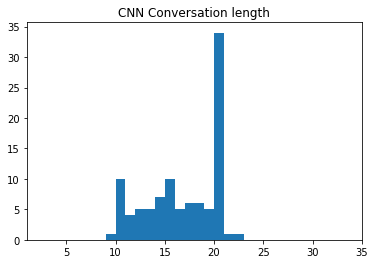

In [37]:
plt.hist(cnn_df.loc[:, 'QA_length'], bins=range(1, 36))
plt.xlim((1, 35))
plt.title("CNN Conversation length")
plt.show()

#plt.hist([answer['span_start'] for answers in cnn_df['answers'] for answer in answers], bins=range(0, 2000, 50))
#plt.show()

In [38]:
def source_eval(models_folder, model_type, with_history, df):
    warnings.filterwarnings('ignore')
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    models = {}
    for model_path in os.listdir(models_folder):
        seed = int(model_path.split('-')[-1])
        history_length = int(model_path.split('-')[-2])
        history = True if history_length > 0 else False

        if model_path.split('-')[0] != model_type or history != with_history:
            continue
        
        params = {'seed': seed, 'history_length': history_length, 'history': history}
        models.update({model_path: (torch.load(models_folder + model_path).to(device), params)})
    
    dialogues = test_conversation(models, df)
    dialogues = dialogues.sort_values(by='f1_score', ascending=True, inplace=False).iloc[:5, :].reset_index(drop=True)
    return dialogues

In [60]:
models_folder = 'Models/'
model_type = 'bert'
with_history = False

dialogues = source_eval(models_folder, model_type, with_history, cnn_df)
dialogues

100%|██████████| 100/100 [06:08<00:00,  3.69s/it]


,source,rationales,questions,answers,preds,tok_pos,pred_tok_pos,f1_score
0,cnn,[American Floyd Mayweather and Filipino Manny ...,[Who are the two boxer featured in this articl...,"[Floyd Mayweather and Manny Pacquiao, 1 is the...","[(his wife., cnn, cnn), (diego pacquiao, tom p...","[(64, 74), (174, 234), (174, 211), (200, 211),...","[[(0, 64), (0, 77), (0, 115), (0, 11), (264, 2...",0.022222
1,cnn,[Redmond O'Neal was on a day pass away from th...,"[Who was on a day pass?, Who is Farrah Fawcett...","[Redmond O'Neal, Redmond O'Neal, cancer, he th...","[(a day pass away, the los angeles, a day), (r...","[(109, 139), (9, 45), (326, 356), (45, 109), (...","[[(112, 120), (13, 19), (10, 16), (27, 37), (1...",0.056645
2,cnn,"[The German news outlet Der Spiegel, The Germa...",[What news agency showed photos of American so...,"[Der Spiegel, Germany, posing over the bodies ...","[(cnn, cnn, cnn), (saudi arabia, afghanistan, ...","[(8, 16), (8, 16), (18, 40), (56, 74), (75, 93...","[[(0, 13), (0, 30), (62, 70), (61, 69), (0, 23...",0.071795
3,cnn,"[The plaintive note read, ""Please, see that my...","[What did David want done with his brain?, wha...","[given to the NFL's brain bank, brain tissue, ...","[(he shot himself in february, his brain damag...","[(53, 77), (77, 102), (82, 102), (119, 138), (...","[[(6, 29), (206, 217), (130, 139), (42, 50), (...",0.073845
4,cnn,[CNN: So you were born in Mexico but grew up i...,"[Who was born in Mexico but not raised there?,...","[Lupita Nyong'o, ""12 Years A Slave., Kenya, He...","[(the young parents, lupita nyong, in his last...","[(276, 318), (5, 39), (278, 290), (196, 202), ...","[[(105, 113), (7, 32), (5, 112), (200, 201), (...",0.080099


In [61]:
def tuple2step(tok_pos):
  tok_pos = list(tok_pos)
  tok_pos.insert(0, 0)
  tok_pos.append(512)
  return tok_pos

In [80]:
def print_worst_dialogues(dialogues):
    y_step = [0, 0, 1, 0]
    for idx, row in dialogues.iterrows():
        print('='*100)
        print('\nPASSAGE ' + str(idx) + '  [f1-score: ' + str(round(row['f1_score'], 4)) + ']', end='\n\n')
        turns = len(row['questions'])
        for t in range(turns):
            print(f'Turn {t}')
            print('Passage    \t-> ', end='')
            print(row['rationales'][t].replace('\n',  ' '))
            print('Question   \t-> ', end='')
            print(row['questions'][t])
            print('Answer     \t-> ', end='')
            print(row['answers'][t])
            print('Predictions\t-> ', end='')
            print('1: ' + row['preds'][t][0], end='     ')
            print('2: ' + row['preds'][t][1], end='     ')
            print('3: ' + row['preds'][t][2], end='\n\n')

            plt.figure(figsize=(10,1))
            plt.step(tuple2step(dialogues['tok_pos'][idx][t]), y_step, c='black')
            plt.step(tuple2step(dialogues['pred_tok_pos'][idx][0][t]), y_step, c='red', linestyle='dotted')
            plt.step(tuple2step(dialogues['pred_tok_pos'][idx][1][t]), y_step, c='blue', linestyle='dotted')
            plt.step(tuple2step(dialogues['pred_tok_pos'][idx][2][t]), y_step, c='lime', linestyle='dotted')
            plt.axis('off')
            plt.legend(["ground truth", "pred 1", "pred 2", "pred 3"], loc ="lower right")
            plt.show()
            print('\n\n')
        print('='*100)


PASSAGE 0  [f1-score: 0.0222]

Turn 0
Passage    	-> American Floyd Mayweather and Filipino Manny Pacquiao
Question   	-> Who are the two boxer featured in this article?
Answer     	-> Floyd Mayweather and Manny Pacquiao
Predictions	-> 1: his wife.     2: cnn     3: cnn



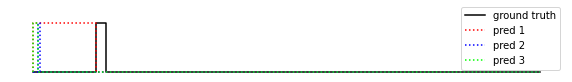




Turn 1
Passage    	-> Thirty-eight year old Mayweather (47-0, 26 knockouts), who favors the moniker "The Money Man" or "TBE" (The Best Ever), boasts nearly five million Instagram followers, 5.65 million followers on Twitter and 9.2 million Facebook likes. 
Question   	-> What is Mayweathers nick name?
Answer     	-> 1 is the money man
Predictions	-> 1: diego pacquiao     2: tom pacquiao     3: nick



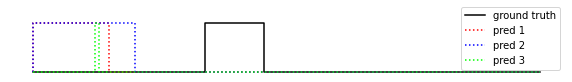




Turn 2
Passage    	-> Thirty-eight year old Mayweather (47-0, 26 knockouts), who favors the moniker "The Money Man" or "TBE" (The Best Ever), 
Question   	-> what is the other
Answer     	-> TBE
Predictions	-> 1: his wife.     2: a boxer's instagram     3: manny pacquiao



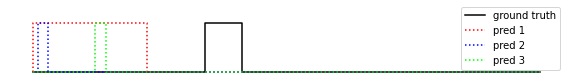




Turn 3
Passage    	-> or "TBE" (The Best Ever),
Question   	-> which stand for?
Answer     	-> The Best Ever
Predictions	-> 1: a chiseled boxer     2: los angeles     3: cnn



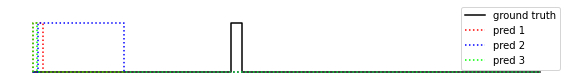




Turn 4
Passage    	->  he's invested in, and displays links to his clothing brand, The Money Team, o
Question   	-> what is the name of his clothing line?
Answer     	-> The Money Team,
Predictions	-> 1: his accounts     2: the bible     3: the money



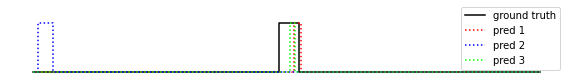




Turn 5
Passage    	->  says boxing promoter Nisse Sauerland,
Question   	-> Who is Sauerland?
Answer     	-> a boxing promoter
Predictions	-> 1: former ceo of team     2: manny pacquiao     3: nisse sauer



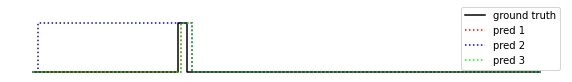




Turn 6
Passage    	-> Sauerland, who promotes over 45 boxers.
Question   	-> how many people does he promote
Answer     	-> over 45 boxers.
Predictions	-> 1: two people     2: three     3: three



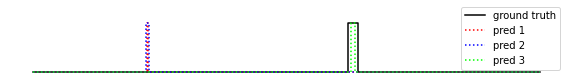




Turn 7
Passage    	-> With the combined purse for the May 2 bout in Las Vegas reported to touch $300 million pending viewership numbers, the incentives to self-promote could not be higher. 
Question   	-> what is the combined purse for this match?
Answer     	-> $300 million pending viewership numbers
Predictions	-> 1: australian open     2: the united states     3: wednesday



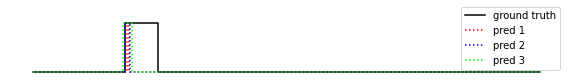




Turn 8
Passage    	-> Thirty-eight year old Mayweather 
Question   	-> how old is mayweather?
Answer     	-> 38
Predictions	-> 1: 47 years old     2: 35 million     3: thirty - eight



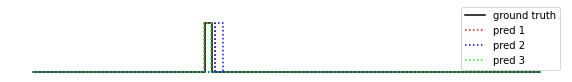




Turn 9
Passage    	->  chiseled boxer's Instagram feed shows him making constant references to the Bible and enjoying gospel singing with his wife. 
Question   	-> what do they say about pacquiao and his following?
Answer     	-> just that it has bible references and shows him enjoying gos[e; singing with his wife
Predictions	-> 1: yes     2: sauerland     3: it's hope



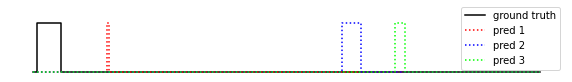





PASSAGE 1  [f1-score: 0.0566]

Turn 0
Passage    	-> Redmond O'Neal was on a day pass away from the Pasadena, California, sober living facility where he is undergoing court-ordered drug rehab.
Question   	-> Who was on a day pass?
Answer     	-> Redmond O'Neal
Predictions	-> 1: a day pass away     2: the los angeles     3: a day



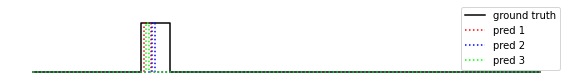




Turn 1
Passage    	-> Farrah Fawcett's son, Redmond O'Neal, visited his mother's grave for the first time Friday, the anniversary of the actress's death.
Question   	-> Who is Farrah Fawcett’s son?
Answer     	-> Redmond O'Neal
Predictions	-> 1: red     2: newmond o'donnell     3: red



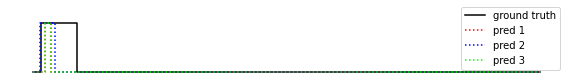




Turn 2
Passage    	-> The foundation has a mission of funding research and clinical trials into alternative treatments for anal cancer -- which killed Fawcett -- and pediatric cancers.
Question   	-> What killed Farrah fawcett?
Answer     	-> cancer
Predictions	-> 1: cnn     2: a newmond     3: his mother's son



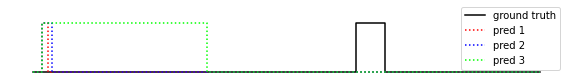




Turn 3
Passage    	-> "It was very nice, very beautifully set up," he said, sitting on a couch between his father, Ryan O'Neal, and sister, Tatum O'Neal. "I'm just happy that I'm able to be there for her and let her know I'm doing all right." 
Question   	-> What did he think of her grave?
Answer     	-> he thought it was nice, very beautifully set up
Predictions	-> 1: the first time friday     2: his father's death.     3: the first time friday



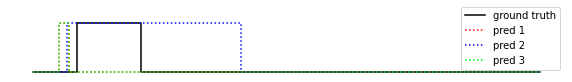




Turn 4
Passage    	-> Redmond O'Neal was on a day pass away from the Pasadena, California, sober living facility where he is undergoing court-ordered drug rehab.
Question   	-> Where was he on a day pass from?
Answer     	-> sober living facility
Predictions	-> 1: california     2: california     3: the palm beach



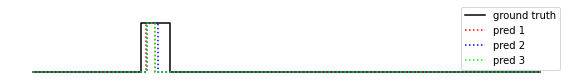




Turn 5
Passage    	-> Redmond O'Neal was on a day pass away from the Pasadena, California, sober living facility where he is undergoing court-ordered drug rehab
Question   	-> Why is he there?
Answer     	-> he is undergoing court-ordered drug rehab
Predictions	-> 1: because they's here     2: his mother's death     3: he's so awesome



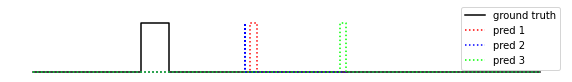




Turn 6
Passage    	-> Farrah Fawcett's son, Redmond O'Neal, visited his mother's grave for the first time Friday, the anniversary of the actress's death. 
Question   	-> where did he visit?
Answer     	-> his mother's grave
Predictions	-> 1: washington, d. c.     2: california     3: o'neal



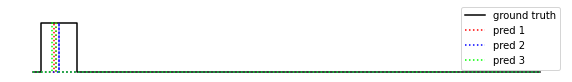




Turn 7
Passage    	-> "It was very nice, very beautifully set up," he said, sitting on a couch between his father, Ryan O'Neal, and sister, Tatum O'Neal. "I'm just happy that I'm able to be there for her and let her know I'm doing all right.
Question   	-> Who was he sitting between?
Answer     	-> his father and sister
Predictions	-> 1: ryan o. neill     2: his father     3: his mother



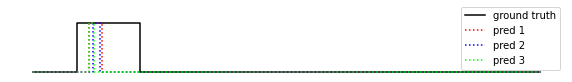




Turn 8
Passage    	-> Farrah Fawcett's son, Redmond O'Neal, visited his mother's grave for the first time Friday, the anniversary of the actress's death
Question   	-> When did he visit her grave?
Answer     	-> Friday
Predictions	-> 1: his mother's     2: friday     3: in the late 19th century



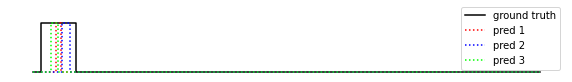




Turn 9
Passage    	-> "Redmond is extremely well," Ryan O'Neal said. "He is recovering from a terrible disease. He seems to have cured himself. We are thrilled about that. And that's why he's here, because they let him.
Question   	-> Who said he seems to have been cured?
Answer     	-> Ryan O'Neal
Predictions	-> 1: mr. edmonstone     2: a disease.     3: an old man



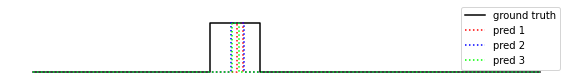




Turn 10
Passage    	-> The three O'Neals were near tears as they spoke exclusively to CNN during a private gathering of friends and family at the Beverly Hills, California, headquarters of the Farrah Fawcett Foundation. 
Question   	-> Where was the gathering?
Answer     	-> Beverly Hills
Predictions	-> 1: a private gathering of friends and family     2: california     3: in a private gathering



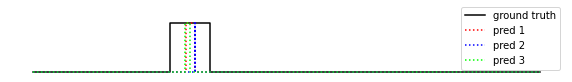




Turn 11
Passage    	-> Farrah Fawcett's son, Redmond O'Neal, visited his mother's grave for the first time Friday, the anniversary of the actress's death
Question   	-> What was significant about Friday?
Answer     	-> it was the anniversary of the actress's death
Predictions	-> 1: the first time friday     2: his mother's death     3: time friday



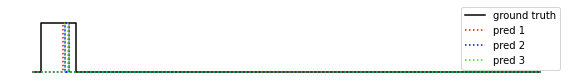




Turn 12
Passage    	-> The three O'Neals were near tears as they spoke exclusively to CNN during a private gathering of friends and family at the Beverly Hills, California, headquarters of the Farrah Fawcett Foundation
Question   	-> Where is the Farrah Fawcett Foundation headquarters?
Answer     	-> California
Predictions	-> 1: newmond o'clock     2: redmond     3: the farrah fawn foundation.



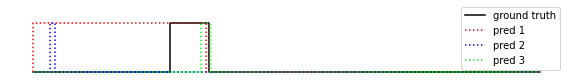




Turn 13
Passage    	-> "It was very nice, very beautifully set up," he said, sitting on a couch between his father, Ryan O'Neal, and sister, Tatum O'Neal. "I'm just happy that I'm able to be there for her and let her know I'm doing all right." 
Question   	-> What is his father’s name?
Answer     	-> Ryan O'Neal
Predictions	-> 1: anthony o'clock     2: his sister     3: ryan



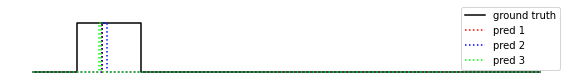




Turn 14
Passage    	-> "Redmond is extremely well," Ryan O'Neal said. "He is recovering from a terrible disease. He seems to have cured himself. We are thrilled about that. And that's why he's here, because they let him." 
Question   	-> How is Redmond doing?
Answer     	-> extremely well
Predictions	-> 1: waiting for her mother's son     2: his mother     3: sitting on his face



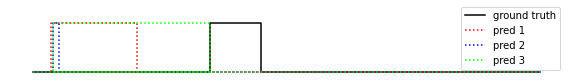




Turn 15
Passage    	-> The foundation has a mission of funding research and clinical trials into alternative treatments for anal cancer -- which killed Fawcett -- and pediatric cancers.
Question   	-> What is the foundation’s mission?
Answer     	-> funding research
Predictions	-> 1: " redmond     2: his mother's death.     3: red



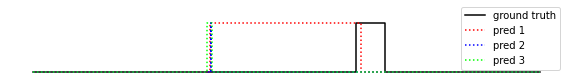




Turn 16
Passage    	-> "And how handsome he is and how much he looks like Farrah," Tatum O'Neal said. "And how proud she would be and how lucky I am that I can at least be here, because he's so awesome. Oh, I'm going to cry."
Question   	-> Who was going to cry?
Answer     	-> Tatum O'Neal
Predictions	-> 1: mrs. edmonstone     2: foundation     3: neals



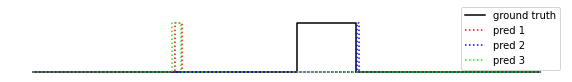





PASSAGE 2  [f1-score: 0.0718]

Turn 0
Passage    	-> The German news outlet Der Spiegel
Question   	-> What news agency showed photos of American soldiers?
Answer     	-> Der Spiegel
Predictions	-> 1: cnn     2: cnn     3: cnn



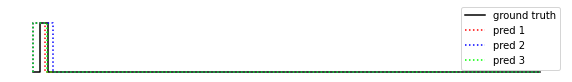




Turn 1
Passage    	-> The German news outlet Der Spiegel
Question   	-> From what country?
Answer     	-> Germany
Predictions	-> 1: saudi arabia     2: afghanistan     3: germany



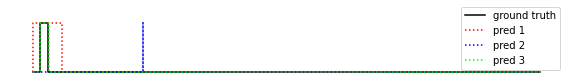




Turn 2
Passage    	-> photographs of what appear to be two U.S. soldiers in Afghanistan posing over the bodies of dead Afghans
Question   	-> What were the soldiers doing in the photos?
Answer     	-> posing over the bodies of dead Afghans
Predictions	-> 1: by a patch     2: trying to death in afghanistan     3: camera show the soldiers



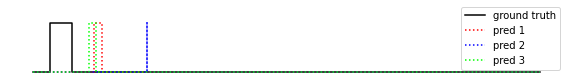




Turn 3
Passage    	-> Two images show the soldiers kneeling by a bloody body sprawled over a patch of sand and grass
Question   	-> What was the condition of the body?
Answer     	-> bloody
Predictions	-> 1: a bloody body     2: a bird     3: lying by a puddle



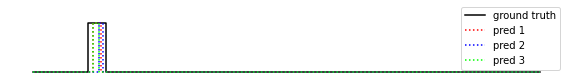




Turn 4
Passage    	-> A third shows what appears to be two bodies propped up, back to bac
Question   	-> What does another photo show?
Answer     	-> propped up, back to back
Predictions	-> 1: cnn     2: a u. s. police department     3: the soldiers



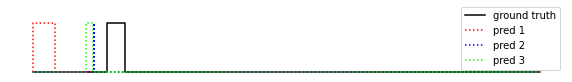




Turn 5
Passage    	->  A third shows what appears to be two bodies propped up, back to back, against a post in front of a military vehicle.  
Question   	-> Near what?
Answer     	-> military vehicle.
Predictions	-> 1: u. s. soldiers     2: in january 2010     3: soldiers



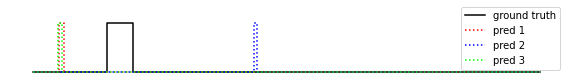




Turn 6
Passage    	-> U.S. military rules also prohibit "taking or retaining individual souvenirs or trophies," which the photographs may be construed as. 
Question   	-> What could the photos be construed as?
Answer     	-> taking or retaining individual souvenirs or trophies
Predictions	-> 1: construction.     2: the u. s. soldiers     3: constudy



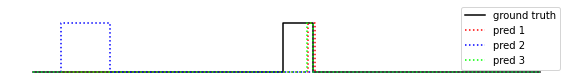




Turn 7
Passage    	-> Der Spiegel identifies the soldiers as Spc. Jeremy Morlock 
Question   	-> What is the name of one of the soldiers?
Answer     	-> Jeremy Morlock
Predictions	-> 1: u. s. soldiers     2: the u. s. police department     3: the german news agency



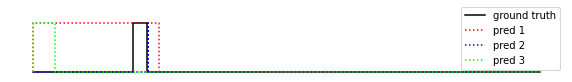




Turn 8
Passage    	-> Pfc. Andrew Holmes
Question   	-> The other?
Answer     	-> Pfc. Andrew Holmes
Predictions	-> 1: two counts of afghan authorities.     2: the u. s.     3: morlock and pfc



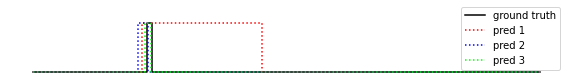




Turn 9
Passage    	-> Holmes is charged with the premeditated deaths of three civilians
Question   	-> What is Holmes being charged with?
Answer     	-> Holmes is charged with the premeditated deaths of three civilians
Predictions	-> 1: murder     2: a u. s. police department     3: two counts of boats



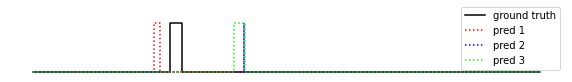





PASSAGE 3  [f1-score: 0.0738]

Turn 0
Passage    	-> The plaintive note read, "Please, see that my brain is given to the NFL's brain bank."
Question   	-> What did David want done with his brain?
Answer     	-> given to the NFL's brain bank
Predictions	-> 1: he shot himself in february     2: his brain damage     3: he shot himself



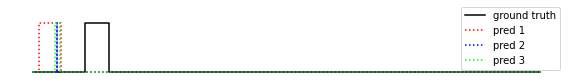




Turn 1
Passage    	-> Today, scientists announced that Duerson's brain tissue showed "moderately advanced" evidence of chronic traumatic encephalopathy
Question   	-> what parts of his brains were discovered to be affected?
Answer     	-> brain tissue
Predictions	-> 1: the kids of 15 former nfl players     2: his brain tumor     3: 15



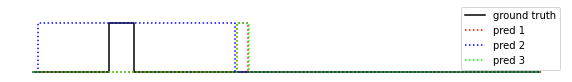




Turn 2
Passage    	-> Duerson's brain tissue showed "moderately advanced" evidence of chronic traumatic encephalopathy
Question   	-> what disease did this show he had?
Answer     	-> chronic traumatic encephalopathy
Predictions	-> 1: no evidence of any other disease     2: dr. ann mckee     3: alzheimer's disease



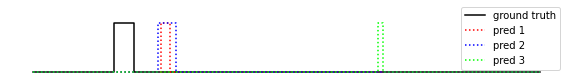




Turn 3
Passage    	-> "Dave Duerson had classic pathology of CTE and no evidence of any other disease,"
Question   	-> any other diseases?
Answer     	-> No
Predictions	-> 1: yes     2: yes     3: no



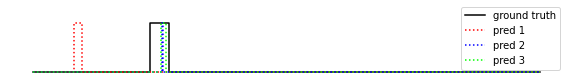




Turn 4
Passage    	-> chronic traumatic encephalopathy, a dementia-like brain disease
Question   	-> what is this disease like?
Answer     	-> a dementia-like brain disease
Predictions	-> 1: football players.     2: his brain tumor     3: alzheimer's.



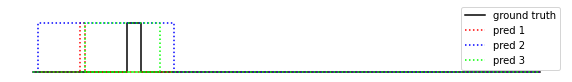




Turn 5
Passage    	-> chronic traumatic encephalopathy, a dementia-like brain disease afflicting athletes exposed to repeated brain trauma.
Question   	-> who usually gets it?
Answer     	-> athletes exposed to repeated brain trauma
Predictions	-> 1: former chicago bears     2: his father     3: dr. mccollombin



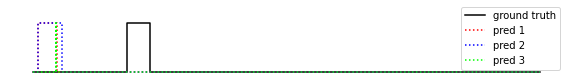




Turn 6
Passage    	-> David Duerson shot himself in the chest
Question   	-> how did David die?
Answer     	-> shot himself in the chest
Predictions	-> 1: he's brain damage     2: his brain damage     3: 50



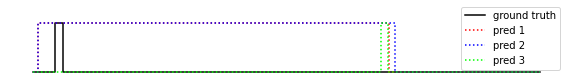




Turn 7
Passage    	-> Chicago Bears safety David Duerson
Question   	-> who did he play for?
Answer     	-> Chicago Bears
Predictions	-> 1: mr. brown     2: dr. mckeep     3: david



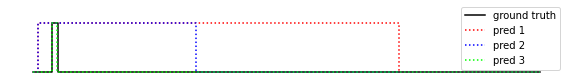




Turn 8
Passage    	-> Chicago Bears safety David Duerson
Question   	-> what position?
Answer     	-> safety
Predictions	-> 1: chairman of his brain damage     2: his brain damage     3: cte and no



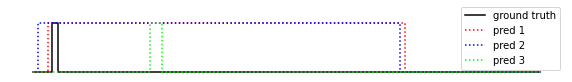




Turn 9
Passage    	-> "Dave Duerson had classic pathology of CTE and no evidence of any other disease," said Dr. Ann McKee, a neuropathologist with the Bedford VA Medical Center
Question   	-> what center is studying this disease?
Answer     	-> Bedford VA Medical Center
Predictions	-> 1: center, and co - director of technology.     2: the new york city     3: medical center, and co - director



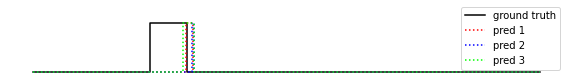




Turn 10
Passage    	-> "Dave Duerson had classic pathology of CTE and no evidence of any other disease," said Dr. Ann McKee, a neuropathologist with the Bedford VA Medical Center, and co-director of the Boston University School of Medicine Center for the Study of Traumatic Encephalopathy
Question   	-> and the other?
Answer     	-> Boston University School of Medicine Center for the Study of Traumatic Encephalopathy
Predictions	-> 1: the university of medicine     2: cte and o'clock     3: one of any other



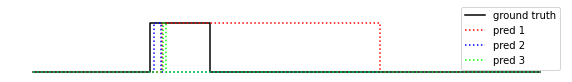




Turn 11
Passage    	-> CTE has been found in the brains of 14 of 15 former NFL players thus far studied at the center.
Question   	-> how many players has the centers studied?
Answer     	-> 15
Predictions	-> 1: two     2: 12     3: four



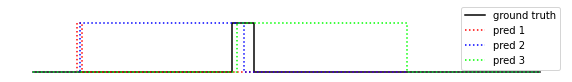




Turn 12
Passage    	-> CTE has been found in the brains of 14 of 15 former NFL players thus far studied at the center.
Question   	-> how many have CTE?
Answer     	-> 14
Predictions	-> 1: 50     2: three     3: four



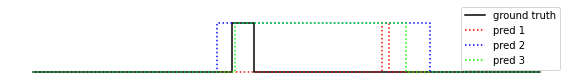




Turn 13
Passage    	-> "He had severe involvement of areas that control judgment, inhibition, impulse control, mood and memory." 
Question   	-> What areas of Davis' brain were impacted?
Answer     	-> areas that control judgment, inhibition, impulse control, mood and memory
Predictions	-> 1: his brain damage     2: the los angeles suburb of areas     3: alzheimer's brain damage



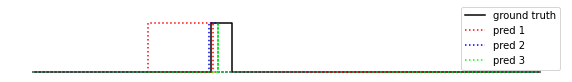




Turn 14
Passage    	-> clumps of a protein called tau
Question   	-> what clumps are caused in the brain by CTE?
Answer     	-> protein
Predictions	-> 1: the brain by cte     2: the brain     3: alzheimer's brain tumor



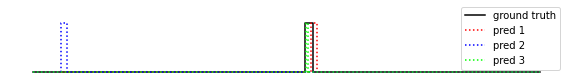





PASSAGE 4  [f1-score: 0.0801]

Turn 0
Passage    	-> CNN: So you were born in Mexico but grew up in Kenya.   LN: Yes, all my conscious memories are in Kenya until when I was 16 my parents sent me back to Mexico to learn Spanish.
Question   	-> Who was born in Mexico but not raised there?
Answer     	-> Lupita Nyong'o
Predictions	-> 1: the young parents     2: lupita nyong     3: in his last year



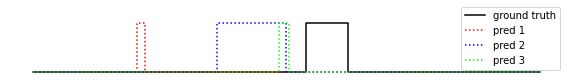




Turn 1
Passage    	->  Kenyan actress Lupita Nyong'o has become a new critics' darling after her breakout role in last year's hit movie "12 Years A Slave."  
Question   	-> What movie was her breakout role in?
Answer     	-> "12 Years A Slave.
Predictions	-> 1: lupita nyong     2: a new york city     3: best actor's biggest role in last year's hit movie.



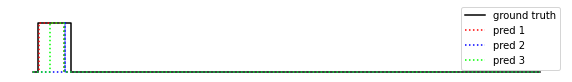




Turn 2
Passage    	-> So you were born in Mexico but grew up in Kenya.  
Question   	-> Where was she raised?
Answer     	-> Kenya
Predictions	-> 1: the best supporting role in last year     2: california     3: ln



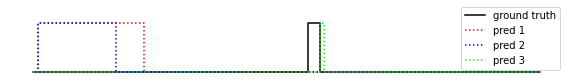




Turn 3
Passage    	-> My father is a politician.
Question   	-> What did her dad do?
Answer     	-> He is a politician.
Predictions	-> 1: president     2: he had a new critics's hit in mexico.     3: vice president



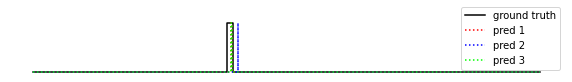




Turn 4
Passage    	-> At the time he was also a professor of political science
Question   	-> What else did he do?
Answer     	-> He was a professor
Predictions	-> 1: dazzle photographers     2: he was born in mexico     3: he was a professor of political science and writer



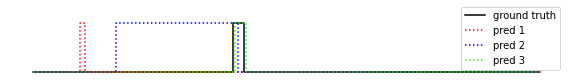




Turn 5
Passage    	-> he was also a professor of political science 
Question   	-> Of what?
Answer     	-> Political science
Predictions	-> 1: a slave.     2: new york     3: new critics



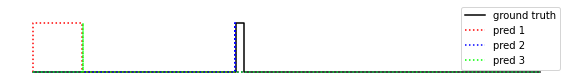




Turn 6
Passage    	-> Yes, all my conscious memories are in Kenya until when I was 16 my parents sent me back to Mexico to learn Spanish.
Question   	-> When did she return to Mexico?
Answer     	-> At 16
Predictions	-> 1: in kenya     2: a week     3: mexico



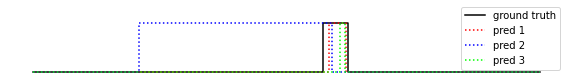




Turn 7
Passage    	-> Yes, all my conscious memories are in Kenya until when I was 16 my parents sent me back to Mexico to learn Spanish.
Question   	-> Why?
Answer     	-> To learn Spanish
Predictions	-> 1: to dazzlement     2: she was born in mexico     3: for independence



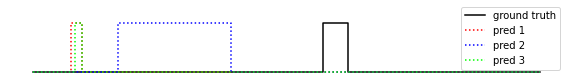




Turn 8
Passage    	->  I grew up in Nairobi, which is the capital of Kenya,
Question   	-> What city did she grow up in?
Answer     	-> Nairobi
Predictions	-> 1: new york     2: kenya     3: mexico



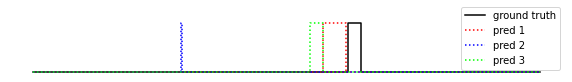




Turn 9
Passage    	-> Since then, the award ceremonies and opportunities to dazzle photographers have been plentiful for Nyong'o, whose mesmerizing performance as Patsey earned her numerous accolades and recognition, including an Oscar nomination for Best Actress in a Supporting Role. 
Question   	-> What was she nominated for?
Answer     	-> An Oscar
Predictions	-> 1: best actress     2: a new critics     3: best actress



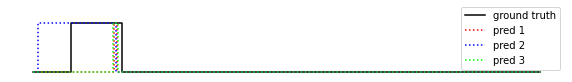




Turn 10
Passage    	-> Since then, the award ceremonies and opportunities to dazzle photographers have been plentiful for Nyong'o, whose mesmerizing performance as Patsey earned her numerous accolades and recognition, including an Oscar nomination for Best Actress in a Supporting Role. 
Question   	-> For what?
Answer     	-> Best Actress in a Supporting Role.
Predictions	-> 1: a new york times.     2: best actress     3: nyong'o'o



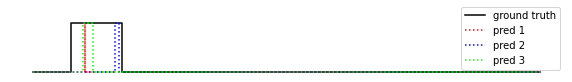




Turn 11
Passage    	-> Since then, the award ceremonies and opportunities to dazzle photographers have been plentiful for Nyong'o, whose mesmerizing performance as Patsey earned her numerous accolades and recognition, including an Oscar nomination for Best Actress in a Supporting Role.  
Question   	-> What was her character's name?
Answer     	-> Patsey
Predictions	-> 1: lupita nyong     2: her husband lupita nyong     3: lupita nyong



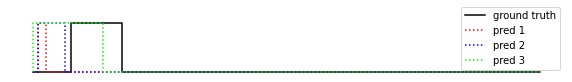

In [81]:
print_worst_dialogues(dialogues)

# Assignment Evaluation

The following assignment points will be awarded for each task as follows:

* Task 1, Pre-processing $\rightarrow$ 0.5 points.
* Task 2, Dataset Splitting $\rightarrow$ 0.5 points.
* Task 3 and 4, Models Definition $\rightarrow$ 1.0 points.
* Task 5 and 6, Models Training and Evaluation $\rightarrow$ 2.0 points.
* Task 7, Analysis $\rightarrow$ 1.0 points.
* Report $\rightarrow$ 1.0 points.

**Total** = 6 points <br>

We may award an additional 0.5 points for outstanding submissions. 
 
**Speed Bonus** = 0.5 extra points <br>

# Report

We apply the rules described in Assignment 1 regarding the report.
* Write a clear and concise report following the given overleaf template (**max 2 pages**).
* Report validation and test results in a table.$^1$
* **Avoid reporting** code snippets or copy-paste terminal outputs $\rightarrow$ **Provide a clean schema** of what you want to show

# Comments and Organization

Remember to properly comment your code (it is not necessary to comment each single line) and don't forget to describe your work!

Structure your code for readability and maintenance. If you work with Colab, use sections. 

This allows you to build clean and modular code, as well as easy to read and to debug (notebooks can be quite tricky time to time).

# FAQ (READ THIS!)

---

**Question**: Does Task 3 also include data tokenization and conversion step?

**Answer:** Yes! These steps are usually straightforward since ```transformers``` also offers a specific tokenizer for each model.

**Example**: 

```
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
encoded_text = tokenizer(text)
%% Alternatively
inputs = tokenizer.tokenize(text, add_special_tokens=True, max_length=min(max_length, 512))
input_ids, attention_mask = inputs['input_ids'], inputs['attention_mask']
```

**Suggestion**: Hugginface's documentation is full of tutorials and user-friendly APIs.

---
---

**Question**: I'm hitting **out of memory error** when training my models, do you have any suggestions?

**Answer**: Here are some common workarounds:

1. Try decreasing the mini-batch size
2. Try applying a different padding strategy (if you are applying padding): e.g. use quantiles instead of maximum sequence length

---
---

# Contact

For any doubt, question, issue or help, you can always contact us at the following email addresses:

Teaching Assistants:

* Andrea Galassi -> a.galassi@unibo.it
* Federico Ruggeri -> federico.ruggeri6@unibo.it

Professor:

* Paolo Torroni -> p.torroni@unibo.it

# The End!

Questions?